# MNIST

In this chapter, we will be using the MNIST dataset, which is a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau

Each image is labeled with the digit it represents. This set has been stud ied so much that it is often called the “Hello World” of Machine Learning: whenever people come up with a new classification algorithm, they are curious to see how it will perform on MNIST

Scikit-Learn provides many helper functions to download popular datasets. MNIST is one of them. The following code fetches the MNIST dataset

In [16]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

Datasets loaded by Scikit-Learn generally have a similar dictionary structure including:
*   A DESCR key describing the dataset 
*   A data key containing an array with one row per instance and one column per feature
*   A target key containing an array with the labels 


Let’s look at these arrays:

In [17]:
X, y = mnist['data'], mnist['target']
X.shape

(70000, 784)

In [18]:
y.shape

(70000,)

There are 70,000 images, and each image has 784 features. This is because each image is 28x28 pixels, and each feature simply represents one pixel’s intensity, from 0 (white) to 255 (black)

Let’s take a peek at one digit from the dataset. All you need to do is grab an instance’s feature vector, reshape it to a array, and display it using Matplotlib’s imshow() function 

(-0.5, 27.5, 27.5, -0.5)

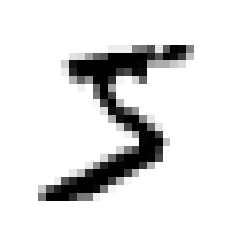

In [19]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
           interpolation='nearest')
plt.axis('off')

This looks like a 5, and indeed that’s what the label tells us:

In [20]:
y[0]

'5'

There should be more than one value in the resulting array. If not, then perhaps what happened is that you used fetch_openml() to download MNIST, and it returns labels as strings so when you defined y_train_5 = (y_train == 5), it results an array full of False. A solution is to cast y_train to int8: y_train = y_train.astype(np.int8)

In [21]:
y = y.astype(np.uint8)

But wait! You should always create a test set and set it aside before inspecting the data closely. The MNIST dataset is actually already split into a training set (the first 60,000 images) and a test set (the last 10,000 images)

In [22]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Let’s also shuffle the training set; this will guarantee that all cross-validation folds will be similar (you don’t want one fold to be missing some digits). Moreover, some learn ing algorithms are sensitive to the order of the training instances, and they perform poorly if they get many similar instances in a row. Shuffling the dataset ensures that this won’t happen

In [23]:
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

# Training a Binary Classifier

Let’s simplify the problem for now and only try to identify one digit—for example, the number 5. This “5-detector” will be an example of a binary classifier, capable of distinguishing between just two classes, 5 and not-5. Let’s create the target vectors for this classification task

In [24]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

Okay, now let’s pick a classifier and train it. A good place to start is with a Stochastic Gradient Descent (SGD) classifier, using Scikit-Learn's SGDClassifier class. This clas sifier has the advantage of being capable of handling very large datasets efficiently

This is in part because SGD deals with training instances independently, one at a time (which also makes SGD well suited for online learning), as we will see later. Let’s create an SGDClassifier and train it on the whole training set 




In [25]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

Now you can use it to detect images of the number 5

In [26]:
sgd_clf.predict([some_digit])

array([False])

# Performance Measures

Evaluating a classifier is often significantly trickier than evaluating a regressor, so we will spend a large part of this chapter on this topic. There are many performance measures available, so grab another coffee and get ready to learn many new concepts and acronyms!

## Measuring Accuracy Using Cross-Validation

Let’s use the cross_val_score() function to evaluate your SGDClassifier model using K-fold cross-validation, with three folds

Remember that K-fold cross validation means splitting the training set into K-folds (in this case, three), then making predictions and evaluating them on each fold using a model trained on the remaining folds

In [27]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.9648, 0.9657, 0.9674])

Wow! Above 95% accuracy (ratio of correct predictions) on all cross-validation folds? This looks amazing, doesn’t it?

Well, before you get too excited, let’s look at a very dumb classifier that just classifies every single image in the “not-5” class

In [28]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
  def fit(self, X, y=None):
    pass
  def predict(self, X):
    return np.zeros((len(X), 1), dtype=bool)

Can you guess this model’s accuracy? Let’s find out

In [29]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91225, 0.90685, 0.90985])

That’s right, it has over 90% accuracy! This is simply because only about 10% of the images are 5s, so if you always guess that an image is not a 5, you will be right about 90% of the time. Beats Nostradamus

This demonstrates why accuracy is generally not the preferred performance measure for classifiers, especially when you are dealing with skewed datasets (i.e., when some classes are much more frequent than others)

## Confusion Matrix

A much better way to evaluate the performance of a classifier is to look at the confu sion matrix. The general idea is to count the number of times instances of class A are classified as class B. For example, to know the number of times the classifier confused images of 5s with 3s, you would look in the 5th row and 3rd column of the confusion matrix

To compute the confusion matrix, you first need to have a set of predictions, so they can be compared to the actual targets. You could make predictions on the test set, but let’s keep it untouched for now (remember that you want to use the test set only at the very end of your project, once you have a classifier that you are ready to launch). Instead, you can use the cross_val_predict() function 

In [30]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Just like the cross_val_score() function, cross_val_predict() performs K-fold cross-validation, but instead of returning the evaluation scores, it returns the predictions made on each test fold. This means that you get a clean prediction for each instance in the training set (“clean” meaning that the prediction is made by a model that never saw the data during training)

Now you are ready to get the confusion matrix using the confusion_matrix() function. Just pass it the target classes (y_train_5) and the predicted classes (y_train_pred) 

In [31]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53639,   940],
       [ 1102,  4319]])

Each row in a confusion matrix represents an actual class, while each column represents a predicted class

The first row of this matrix considers non-5 images (the nega tive class): 53,272 of them were correctly classified as non-5s (they are called true negatives), while the remaining 1,307 were wrongly classified as 5s (false positives)

The second row considers the images of 5s (the positive class): 1,077 were wrongly classified as non-5s (false negatives), while the remaining 4,344 were correctly classi fied as 5s (true positives)

A perfect classifier would have only true positives and true negatives, so its confusion matrix would have nonzero values only on its main diagonal (top left to bottom right)

In [32]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

## Precision and Recall

Scikit-Learn provides several functions to compute classifier metrics, including precision and recall

In [33]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)


0.8212587944476136

In [34]:
recall_score(y_train_5, y_train_pred)

0.7967164729754658

Now your 5-detector does not look as shiny as it did when you looked at its accuracy. When it claims an image represents a 5, it is correct only 72% of the time. Moreover, it only detects 70% of the 5s

To compute the F1 score, simply call the f1_score() function

In [35]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.8088014981273408

## Precision/Recall Tradeof

To understand this tradeoff, let’s look at how the SGDClassifier makes its classifiction decisions

For each instance, it computes a score based on a decision function, and if that score is greater than a threshold, it assigns the instance to the positive class, or else it assigns it to the negative class

Scikit-Learn does not let you set the threshold directly, but it does give you access to the decision scores that it uses to make predictions. Instead of calling the classifier’ method, you can call its method, which returns a predict() decision_function() score for each instance, and then make predictions based on those scores using any threshold you want

In [36]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([-1674.31533102])

In [37]:
thershold = 0
y_some_digit_pred = (y_scores > thershold)
y_some_digit_pred

array([False])

The SGDClassifier uses a threshold equal to 0, so the previous code returns the same result as the predict() method (i.e., True). Let’s raise the threshold 

In [38]:
thershold = 200000
y_some_digit_pred = (y_scores > thershold)
y_some_digit_pred

array([False])

This confirms that raising the threshold decreases recall. The image actually repre sents a 5, and the classifier detects it when the threshold is 0, but it misses it when the threshold is increased to 200,000

So how can you decide which threshold to use? For this you will first need to get the scores of all instances in the training set using the cross_val_predict() function again, but this time specifying that you want it to return decision scores instead of predictions

In [39]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method='decision_function')

In [40]:
# hack to work around issue #9589 in Scikit-Learn 0.19.0
if y_scores.ndim == 2:
    y_scores = y_scores[:, 1]

Now with these scores you can compute precision and recall for all possible thresh olds using the precision_recall_curve() function 

In [41]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thersholds = precision_recall_curve(y_train_5, y_scores)

Finally, you can plot precision and recall as functions of the threshold value using
Matplotlib

In [42]:
def plot_precision_recall_vs_thershold(precisions, recalls, thersholds):
  plt.plot(thersholds, precisions[:-1], 'b--', label='Precision')
  plt.plot(thersholds, recalls[:-1], 'g-', label='Recall')
  plt.xlabel('Thershold')
  plt.legend(loc='upper left')
  plt.ylim([0,1])
  plt.xlim([-100000, 45000]) 

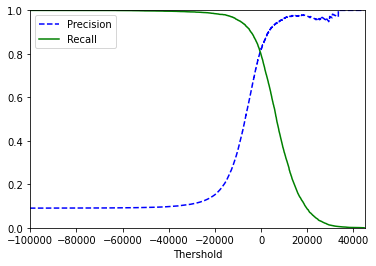

In [43]:
plot_precision_recall_vs_thershold(precisions, recalls, thersholds)
plt.show()

Now you can simply select the threshold value that gives you the best precision/recall tradeoff for your task. Another way to select a good precision/recall tradeoff is to plot precision directly against recall

In [44]:
def plot_precision_versus_recall(precisions, recalls):
  plt.plot(recalls, precisions)
  plt.xlabel('Recall')
  plt.ylabel('Precisions')
  plt.xlim(0, 1)
  plt.ylim(0, 1)

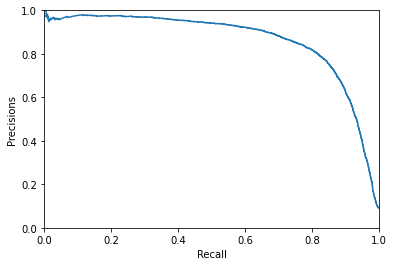

In [45]:
plot_precision_versus_recall(precisions, recalls)

You can see that precision really starts to fall sharply around 80% recall. You will probably want to select a precision/recall tradeoff just before that drop—for example, at around 60% recall. But of course the choice depends on your project

So let’s suppose you decide to aim for 90% precision. You look up the first plot (zooming in a bit) and find that you need to use a threshold of about 70,000 (5,000 for this case). To make predictions (on the training set for now), instead of calling the classifier’s predict() method, you can just run this code

In [46]:
y_train_pred_90 = (y_scores > 5000)

Let’s check these predictions’ precision and recall

In [47]:
precision_score(y_train_5, y_train_pred_90)

0.9258387286639199

In [48]:
recall_score(y_train_5, y_train_pred_90)

0.580335731414868

Great, you have a 90% precision classifier (or close enough)! As you can see, it is fairly easy to create a classifier with virtually any precision you want: just set a high enough threshold, and you’re done. Hmm, not so fast. A high-precision classifier is not very useful if its recall is too low

## The ROC Curve

The receiver operating characteristic (ROC) curve is another common tool used with binary classifiers. It is very similar to the precision/recall curve, but instead of plot ting precision versus recall, the ROC curve plots the true positive rate (another name for recall) against the false positive rate

The FPR is the ratio of negative instances that are incorrectly classified as positive. It is equal to one minus the true negative rate, which is the ratio of negative instances that are correctly classified as negative

The TNR is also called specificity. Hence the ROC curve plots sensitivity (recall) versus 1 – specificity

To plot the ROC curve, you first need to compute the TPR and FPR for various thres hold values, using the function roc_curve()

In [49]:
from sklearn.metrics import roc_curve

fpr, tpr, thersholds = roc_curve(y_train_5, y_scores)

Then you can plot the FPR against the TPR using Matplotlib

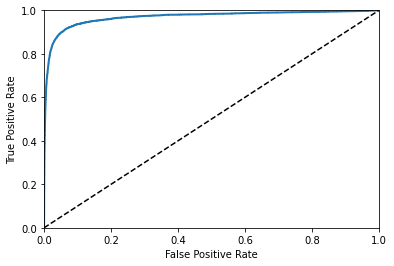

In [50]:
def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.axis([0, 1, 0, 1])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')

plot_roc_curve(fpr, tpr)

Once again there is a tradeoff: the higher the recall (TPR), the more false positives (FPR) the classifier produces

The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner)


One way to compare classifiers is to measure the area under the curve (AUC)

A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5. Scikit-Learn provides a function to compute the ROC AUC

In [51]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9686962293138991

Let’s train a and compare its ROC curve and ROC AUC RandomForestClassifier score to the SGDClassifier

First, you need to get scores for each instance in the training set. But due to the way it works (see Chapter 7), the RandomForestClassifier class does not have a decision_function() method. Instead it has a  predict_proba() method. Scikit-Learn classifiers generally have one or the other 

The method returns an array containing a row per instance and a col predict_proba() umn per class, each containing the probability that the given instance belongs to the given class (e.g., 70% chance that the image represents a 5)

In [52]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method='predict_proba')

But to plot a ROC curve, you need scores, not probabilities. A simple solution is to use the positive class’s probability as the score

In [53]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thersholds_forest = roc_curve(y_train_5, y_scores_forest)

Now you are ready to plot the ROC curve. It is useful to plot the first ROC curve as well to see how they compare

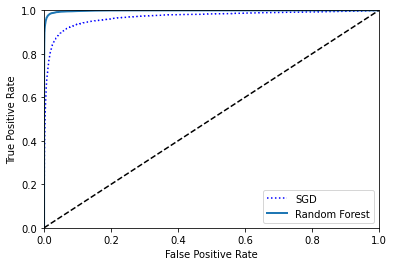

In [54]:
plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend(loc='lower right')

the RandomForestClassifier’s ROC curve looks much better than the SGDClassifier’s: it comes much closer to the top-left corner. As a result, its ROC AUC score is also significantly better

In [55]:
roc_auc_score(y_train_5, y_scores_forest)

0.9984589017199789

Try measuring the precision and recall scores: you should find 98.5% precision and 82.8% recall. Not too bad

Hopefully you now know how to train binary classifiers, choose the appropriate met ric for your task, evaluate your classifiers using cross-validation, select the precision/ recall tradeoff that fits your needs, and compare various models using ROC curves and ROC AUC scores. Now let’s try to detect more than just the 5s

# Multiclass Classification

Whereas binary classifiers distinguish between two classes, multiclass classifiers (also called multinomial classifiers) can distinguish between more than two classes

Some algorithms (such as Random Forest classifiers or naive Bayes classifiers) are capable of handling multiple classes directly. Others (such as Support Vector Machine classifiers or Linear classifiers) are strictly binary classifiers. However, there are vari ous strategies that you can use to perform multiclass classification using multiple binary classifiers

For example, one way to create a system that can classify the digit images into 10 classes (from 0 to 9) is to train 10 binary classifiers, one for each digit (a 0-detector, a 1-detector, a 2-detector, and so on). Then when you want to classify an image, you get the decision score from each classifier for that image and you select the class whose classifier outputs the highest score. This is called the one-versus-all (OvA) strategy (also called one-versus-the-rest)

Another strategy is to train a binary classifier for every pair of digits: one to distin guish 0s and 1s, another to distinguish 0s and 2s, another for 1s and 2s, and so on. This is called the one-versus-one (OvO) strategy. If there are N classes, you need to train N (N – 1) / 2 classifiers

For the MNIST problem, this means training 45 binary classifiers! When you want to classify an image, you have to run the image through all 45 classifiers and see which class wins the most duels. The main advan tage of OvO is that each classifier only needs to be trained on the part of the training set for the two classes that it must distinguish

Some algorithms (such as Support Vector Machine classifiers) scale poorly with the size of the training set, so for these algorithms OvO is preferred since it is faster to train many classifiers on small training sets than training few classifiers on large training sets. For most binary classification algorithms, however, OvA is preferred

Scikit-Learn detects when you try to use a binary classification algorithm for a multi class classification task, and it automatically runs OvA (except for SVM classifiers for which it uses OvO). Let’s try this with the SGDClassifier

In [56]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([5], dtype=uint8)

That was easy! This code trains the SGDClassifier on the training set using the original target classes from 0 to 9 (y_train), instead of the 5-versus-all target classes (y_train_5). Then it makes a prediction (a correct one in this case)

Under the hood, Scikit-Learn actually trained 10 binary classifiers, got their decision scores for the image, and selected the class with the highest score

To see that this is indeed the case, you can call the method. decision_function() Instead of returning just one score per instance, it now returns 10 scores, one per class

In [57]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-24578.0242504 , -39180.06935234,  -8622.98749224,
         -2224.90727377, -17562.4889534 ,   -509.62196653,
        -31540.5041089 , -14796.77394877, -13490.21990321,
        -10623.84670214]])

The highest score is indeed the one corresponding to class 5

In [58]:
np.argmax(some_digit_scores)

5

In [59]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [60]:
sgd_clf.classes_[5]

5

If you want to force ScikitLearn to use one-versus-one or one-versus-all, you can use the OneVsOneClassifier or classes OneVsRestClassifier




Simply create an instance and pass a binary classifier to its constructor. For example, this code creates a multiclass classifier using the OvO strategy, based on a SGDClassifier

In [61]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5], dtype=uint8)

In [62]:
len(ovo_clf.estimators_)

45

Training a is just as easy RandomForestClassifier

In [63]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5], dtype=uint8)

This time Scikit-Learn did not have to run OvA or OvO because Random Forest classifiers can directly classify instances into multiple classes

You can call predict_proba() to get the list of probabilities that the classifier assigned to each instance for each class

In [64]:
forest_clf.predict_proba([some_digit])

array([[0.01, 0.01, 0.01, 0.03, 0.  , 0.9 , 0.  , 0.  , 0.02, 0.02]])

You can see that the classifier is fairly confident about its prediction: the 0.9 at the 5th index in the array means that the model estimates a 90% probability that the image represents a 5

It also thinks that the image could instead be a 2, a 3 or a 8, respec tively with 1%, 8% and 1% probability

Now of course you want to evaluate these classifiers. As usual, you want to use cross validation. Let’s evaluate the SGDClassifier’s accuracy using the cross_val_score() function

In [65]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87305, 0.8849 , 0.8756 ])

It gets over 84% on all test folds. If you used a random classifier, you would get 10% accuracy, so this is not such a bad score, but you can still do much better. For exam ple, simply scaling the inputs (as discussed in Chapter 2) increases accuracy above 89%

In [66]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.90185, 0.9006 , 0.9018 ])

# Error Analysis

Of course, if this were a real project, you would follow the steps in your Machine Learning project checklist: exploring data preparation options, trying out multiple models, shortlisting the best ones and fine-tuning their hyperparameters using GridSearchCV, and automating as much as possible, as you did in the previous chapter

Here, we will assume that you have found a promising model and you want to find ways to improve it. One way to do this is to analyze the types of errors it makes

First, you can look at the confusion matrix. You need to make predictions using the cross_val_predict() function, then call the confusion_matrix() function, just like you did earlier

In [67]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([[5593,    0,   17,    7,    9,   49,   36,    5,  206,    1],
       [   0, 6419,   50,   19,    3,   43,    5,    9,  182,   12],
       [  27,   28, 5249,   81,   76,   24,   81,   38,  343,   11],
       [  28,   20,  112, 5239,    1,  210,   26,   43,  380,   72],
       [   9,   14,   47,    9, 5248,    9,   36,   20,  295,  155],
       [  31,   19,   30,  162,   52, 4478,   81,   23,  487,   58],
       [  27,   17,   46,    1,   45,   83, 5562,    5,  132,    0],
       [  21,   16,   49,   23,   45,   11,    5, 5720,  168,  207],
       [  15,   66,   38,   93,    1,  121,   30,    9, 5437,   41],
       [  21,   23,   30,   57,  122,   41,    1,  180,  334, 5140]])

That’s a lot of numbers. It’s often more convenient to look at an image representation of the confusion matrix, using Matplotlib’s matshow() function 

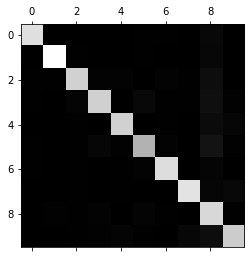

In [68]:
plt.matshow(conf_mx, cmap=plt.cm.gray)

This confusion matrix looks fairly good, since most images are on the main diagonal, which means that they were classified correctly

The 5s look slightly darker than the other digits, which could mean that there are fewer images of 5s in the dataset or that the classifier does not perform as well on 5s as on other digits. In fact, you can verify that both are the case

Let’s focus the plot on the errors. First, you need to divide each value in the confusion matrix by the number of images in the corresponding class, so you can compare error rates instead of absolute number of errors (which would make abundant classes look unfairly bad)

In [69]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

Now let’s fill the diagonal with zeros to keep only the errors, and let’s plot the result

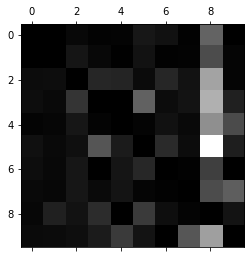

In [70]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)

Now you can clearly see the kinds of errors the classifier makes. Remember that rows represent actual classes, while columns represent predicted classes. The column for class 8 is quite bright, which tells you that many images get misclassified as 8s

How ever, the row for class 8 is not that bad, telling you that actual 8s in general get prop erly classified as 8s. As you can see, the confusion matrix is not necessarily symmetrical. You can also see that 3s and 5s often get confused (in both directions)

Analyzing the confusion matrix can often give you insights on ways to improve your classifier. Looking at this plot, it seems that your efforts should be spent on reducing the false 8s. For example, you could try to gather more training data for digits that look like 8s (but are not) so the classifier can learn to distinguish them from real 8s

Or you could engineer new features that would help the classifier—for example, writ ing an algorithm to count the number of closed loops (e.g., 8 has two, 6 has one, 5 has none). Or you could preprocess the images (e.g., using Scikit-Image, Pillow, or OpenCV) to make some patterns stand out more, such as closed loops



Analyzing individual errors can also be a good way to gain insights on what your classifier is doing and why it is failing, but it is more difficult and time-consuming

For example, let’s plot examples of 3s and 5s (the function just uses plot_digits() Matplotlib’s imshow() function; see this chapter’s Jupyter notebook for details) 

In [73]:
import matplotlib as mpl
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

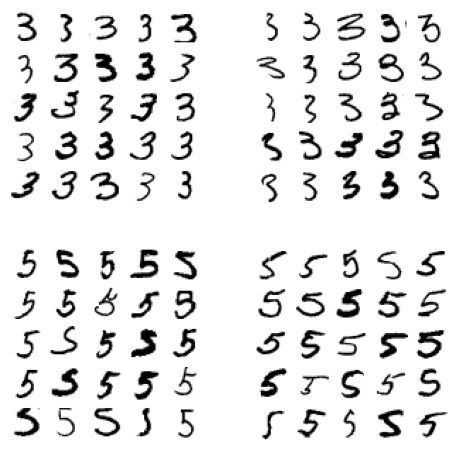

In [75]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)

The two blocks on the left show digits classified as 3s, and the two blocks on the right show images classified as 5s. Some of the digits that the classifier gets wrong (i.e., in the bottom-left and top-right blocks) are so badly written that even a human would have trouble classifying them

However, most misclassified images seem like obvious errors to us, and it’s hard to understand why the classifier made the mistakes it did. 3 The reason is that we used a simple SGDClassifier, which is a linear model. All it does is assign a weight per class to each pixel, and when it sees a new image it just sums up the weighted pixel intensities to get a score for each class. So since 3s and 5s differ only by a few pixels, this model will easily confuse them

The main difference between 3s and 5s is the position of the small line that joins the top line to the bottom arc. If you draw a 3 with the junction slightly shifted to the left, the classifier might classify it as a 5, and vice versa. In other words, this classifier is quite sensitive to image shifting and rotation. So one way to reduce the 3/5 confusion would be to preprocess the images to ensure that they are well centered and not too rotated. This will probably help reduce other errors as well

# Multilabel Classification

Until now each instance has always been assigned to just one class. In some cases you may want your classifier to output multiple classes for each instance

For example, consider a face-recognition classifier: what should it do if it recognizes several people on the same picture? Of course it should attach one tag per person it recognizes. Say the classifier has been trained to recognize three faces, Alice, Bob, and Charlie; then when it is shown a picture of Alice and Charlie, it should output [1, 0, 1] (meaning “Alice yes, Bob no, Charlie yes”

Such a classification system that outputs multiple binary tags is called a multilabel classification system

We won’t go into face recognition just yet, but let’s look at a simpler example, just for illustration purposes

In [77]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')